In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from stats_utils import *
from matter import *
import seaborn as sns

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05)

In [3]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [71]:
orders = np.array([0, 2, 3, 4])
body = 'NN-only'
# body = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
# valid1 = slice(2, None, 5)
[fit_n2lo, fit_n3lo] = fits[Lambda]

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)

kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
    WhiteKernel(noise_level=1e-10, noise_level_bounds='fixed')
kernel1_theta = kernel1.theta
ref1 = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=5,
    scale=1.
)


mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask1 = \
    (df['Body'] == body) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n = df[mask1 & (df['x'] == 0)]
df_s = df[mask1 & (df['x'] == 0.5)]

kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
density = df_n[df_n['OrderEFT'] == 'LO']['n'].values
kf_d = kf_n.copy()

valid1 = np.arange(len(kf_n)) % 5 == 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
y1_d = y1_n - y1_s

c1_n = gm.coefficients(y1_n, ratio(kf_n, Lb), ref=ref1, orders=orders)
c1_s = gm.coefficients(y1_s, ratio(kf_s, Lb), ref=ref1, orders=orders)
c1_d = gm.coefficients(y1_d, ratio(kf_d, Lb), ref=ref1, orders=orders)

In [72]:
kernel1.hyperparameters

[Hyperparameter(name='k1__length_scale', value_type='numeric', bounds=array([[1.e-02, 1.e+02]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__noise_level', value_type='numeric', bounds='fixed', n_elements=1, fixed=True)]

In [73]:
kernel1.n_dims

1

In [74]:
df_n['OrderEFT'].unique()

array(['LO', 'NLO', 'N2LO', 'N3LO'], dtype=object)

In [75]:
analysis_n = MatterConvergenceAnalysis(
    X=Kf_n, y=y1_n, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, **hyperparams
)
analysis_s = MatterConvergenceAnalysis(
    X=Kf_s, y=y1_s, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, **hyperparams
)
analysis_d = MatterConvergenceAnalysis(
    X=Kf_d, y=y1_d, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, **hyperparams
)

Can take a while if a large breakdown/ls grid is used

In [76]:
analysis_n.setup_posteriors(breakdown=Lb_vals, ls=ls_vals, max_idx=[2, 3], logprior=None)
analysis_s.setup_posteriors(breakdown=Lb_vals, ls=ls_vals, max_idx=[2, 3], logprior=None)
analysis_d.setup_posteriors(breakdown=Lb_vals, ls=ls_vals, max_idx=[2, 3], logprior=None);

In [78]:
df_Lb_pdf_all = analysis_n.df_breakdown.copy()
df_Lb_pdf_all['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf'] * analysis_d.df_breakdown['pdf']
df_Lb_pdf_all['system'] = 'All'

In [88]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'{key}-{value}_'
    return s[:-1]

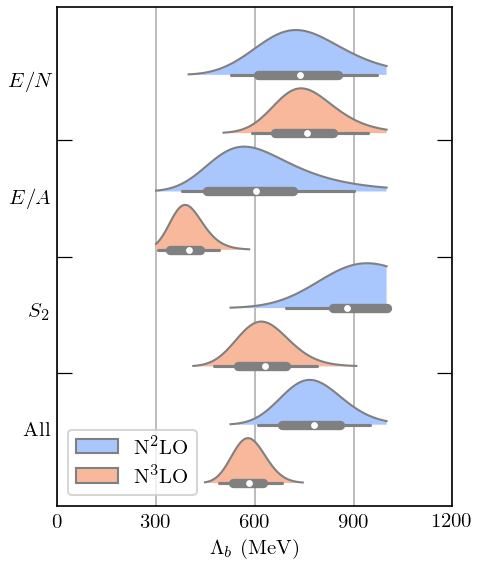

In [84]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(f'breakdown_posteriors_all_{dict_to_str(hyperparams)}')

In [87]:
str(hyperparams)

"{'center': 0, 'disp': 0, 'df': 5, 'scale': 1.0}"

In [89]:
f'{dict_to_str(hyperparams)}'

'center-0_disp-0_df-5_scale-1.0'

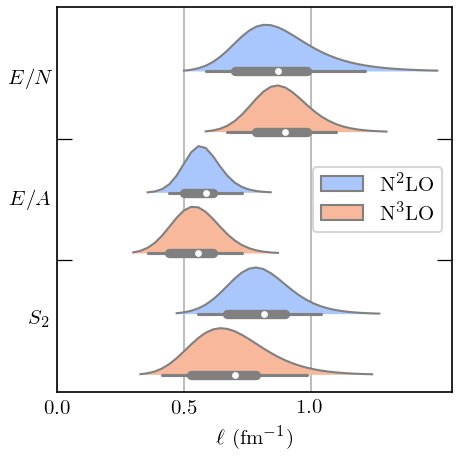

In [40]:
df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls, analysis_d.df_ls])
ax = pdfplot(
    x=r'$\ell$ (fm$^{-1}$)', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
        palette="coolwarm", saturation=1., ax=None, margin=0.3,
)
ax.set_xticks([0, 0.5, 1.]);
ax.grid(axis='x');
ax.set_axisbelow(True);

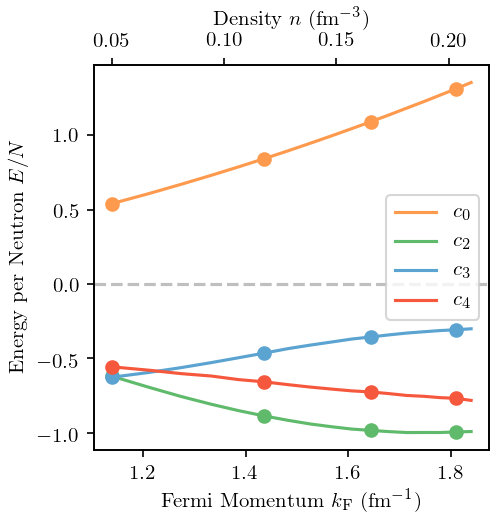

In [11]:
analysis_n.plot_coefficients(breakdown=Lb);

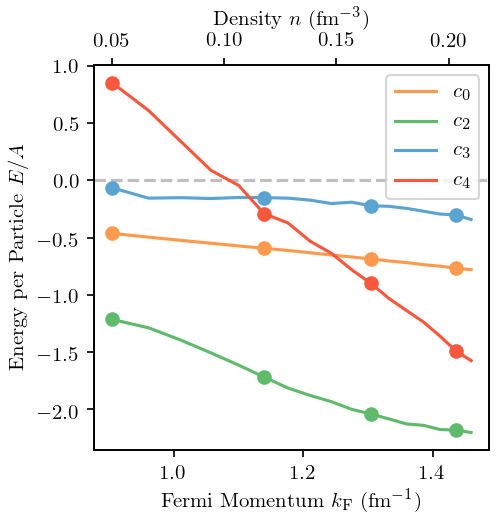

In [12]:
analysis_s.plot_coefficients(breakdown=Lb);

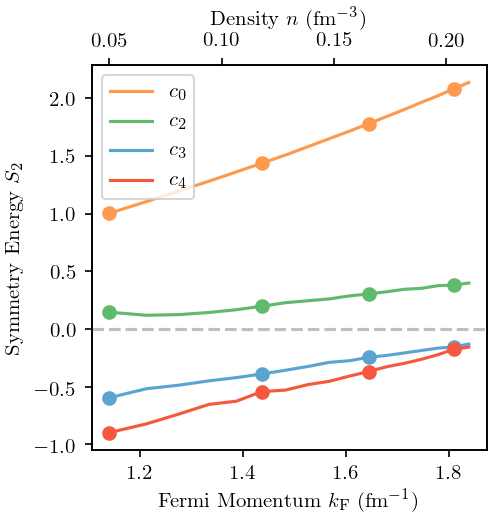

In [13]:
analysis_d.plot_coefficients(breakdown=Lb);

Make the dataframes attributes of the class for cleanliness.

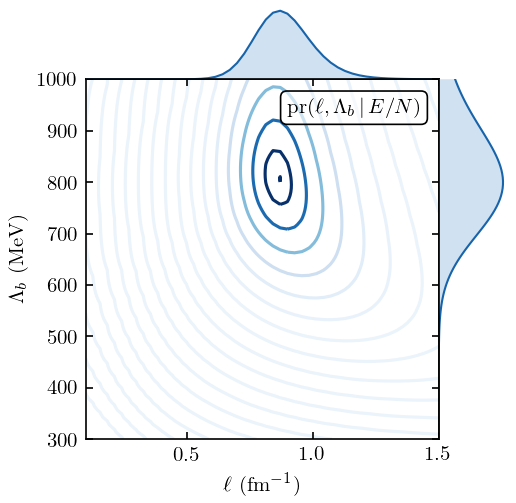

In [18]:
fig = analysis_n.plot_joint_breakdown_ls(max_idx=3)

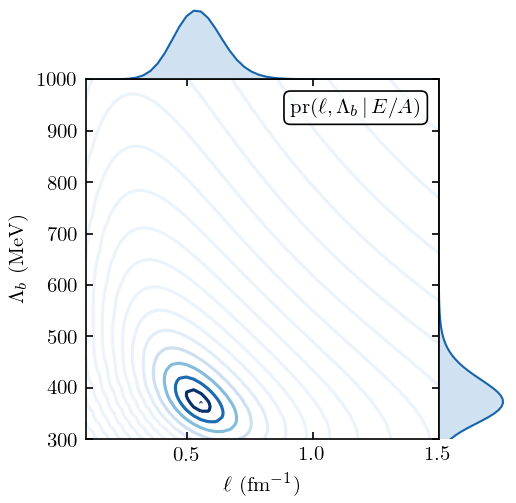

In [19]:
fig = analysis_s.plot_joint_breakdown_ls(max_idx=3)

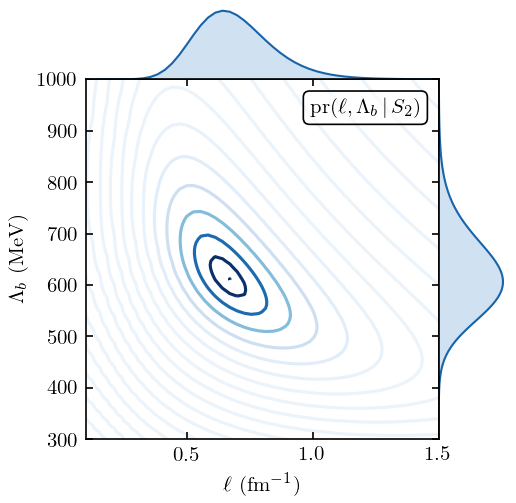

In [20]:
fig = analysis_d.plot_joint_breakdown_ls(max_idx=3)